> 这是一个简单的辅助震相标定的工具，UI界面尚且粗糙，但多数功能可用。</br>
> 该项目可能会停止维护。

## 1、导入必须的Python库

In [1]:
import os
import time
import glob
import datetime
from threading import Thread
# 基础科学计算
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# osbpy
from obspy import read
from obspy.signal.trigger import (classic_sta_lta, z_detect, recursive_sta_lta, carl_sta_trig, delayed_sta_lta)
# GUI
import bqplot as bq
import ipywidgets as widgets
from IPython.display import display
from ipywidgets.widgets import Layout, VBox, HBox, HTML
from ipywidgets.widgets import Label, FloatProgress, FloatSlider, Button, Accordion, ToggleButtons, Tab, Dropdown, RadioButtons, FloatRangeSlider, FloatText

# 日志配置
import logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s: %(message)s')

**一些基本信息：SAC头段变量**
- b: 文件起始时间，相对于参考时刻秒数；
- e: 文件结束时间，相对于参考时刻秒数；
- o: 地震事件相对于参考时刻秒数；
- a: 存储地震事件初至时间，如果a中包含P波到时，此时ka值可以设置为"P"；
- f: 存储地震事件结束时间；
- t1: 自定义时间时刻，包含震相PcP到时，一般定义为kt1为"PcP"
- 初步处理后的数据，t1有值，kt1为P
- 处理后数据，将到时存储到a中，ka为P

**地震事件信息**
- seisfloder: 包含地震事件的文件夹
- seisstation: 包含地震台站的文件夹
- outputfolder: 输出文件夹
- targetkey: 要将标定P波写入的字段
- targetkeystr: 记录字段含义的字段，ka
- targetstrvalue: 记录字段写入的值
- model: 设计好的模式，自动循环模式，手动选择模式，全自动选择模式
- change model: 按钮控制的模式, event, station

In [2]:
SeisFolders = r"D:\VirtualboxData\Lab\Data\event8_reprocess\event8\v3_mark"
OutputFolder = r"D:\VirtualboxData\Lab\Data\event8_reprocess\event8\v3_mark"
OriginKey="t1"
TargetKey = "a"
TargetKeyStr = "ka"
TargetKeyStrValue = "P"

assert os.path.exists(OutputFolder), "输出文件夹不存在"

ModelSet = ["Auto Loop", "Manual", "Auto Plot"]
# 模式 Event, Station
ChangeMode = "Station"

In [3]:
# 初始化的随机地震数据，无意义
SesiData = {"x":np.arange(0,100), "y":np.random.randn(100)
            # 该参数初始值设计检测算法计算，置0会报错
            , "sampling_rate":10
            , OriginKey:0, "b":0, TargetKey:0, "t1_relative":0, "p_relative":0, "name":"init"}
# 标记P波的位置
MarkPValue = SesiData["p_relative"]
# 自动标定P波的位置
OriginPValue = SesiData["t1_relative"]

- 各算法参数

In [4]:
# 算法1
Alg1_Sta, Alg1_Lta = 5, 10
Alg1_Trig1, Alg1_Trig2 = 0.5, 1.5
# 算法2
Z_Detect, Alg2_Trig1, Alg2_Trig2 = 5, -0.4, 0.3
# 算法3
Alg3_Sta, Alg3_Lta = 5, 10
Alg3_Trig1, Alg3_Trig2 = 0.5, 1.5
# 算法4
Alg4_Sta, Alg4_Lta, Alg4_Carl1, Alg4_Carl2 = 5, 10, 0.8, 0.8
Alg4_Trig1, Alg4_Trig2 = -20, 20
# 算法5
Alg5_Sta, Alg5_Lta = 2, 4
Alg5_Trig1, Alg5_Trig2 = 5, 10

In [5]:
# 算法数据
AlgorithmData = {"classic_sta_lta":np.random.randn(100), "z_detect":np.random.randn(100), "recursive_sta_lta":np.random.randn(100), "carl_sta_trig":np.random.randn(100), "delayed_sta_lta":np.random.randn(100)}

- 窗口高度

In [6]:
MiddleFigHeight = "200px"
BottomFigHeight = "200px"

- CSV 记录工具

In [7]:
## 待处理

## 2、读取数据

- 获取地震事件的文件夹路径

In [8]:
def getSeisFolders(folder, event="*"):
    '''读取地震数据'''
    if(os.path.isdir(folder)):
        items = glob.glob(os.path.join(folder, event))
        values = [i for i in items if os.path.isdir(i)]
        keys = [os.path.split(i)[-1] for i in values]
        
        logging.info("更新地震事件文件夹:{} 数量:{}".format(folder, len(values)))
        return [i for i in zip(keys, values)]
    
    else:
        logging.warning("文件夹路径不存在：{}".format(folder))
    return []

- 获取地震事件的台站路径

In [9]:
def getSeisStations(folder, station="*.Z"):
    '''读取地震台站'''
    if(os.path.isdir(folder)):
        items = glob.glob(os.path.join(folder, station))
        if(len(items)):
            values = items
            # 出错请尝试修改，或者直接注释掉
            values = sorted(items, key=lambda x: int(x.split(".")[-2]))
            
            keys = [os.path.split(i)[-1] for i in values]
            logging.debug("更新地震事件台站:{} 数量:{}".format(folder, len(values)))
            return [i for i in zip(keys, values)]
    else:
        logging.warning("文件夹路径不存在：{}".format(folder))
            
    return []

- 获取地震数据

In [10]:
def getKey(item, key, nan=0):
    return nan if(key not in item.keys()) else item[key]

def readSeisData(path, number=0):
    '''读取数据'''
    if(os.path.exists(path)):
        # 读取
        filename = os.path.split(path)[-1]
        data = read(path)
        # 判断序列
        if(number < len(data)):
            temp = {
                "x": data[number].times("relative"),
                "y": data[number].data,
                "sampling_rate": data[number].stats["sampling_rate"],
                "t1": getKey(data[number].stats["sac"], OriginKey),
                "b": getKey(data[number].stats["sac"], "b"),
                "a": getKey(data[number].stats["sac"], TargetKey),
                "name": filename
            }
            # 计算p波时间
            temp["t1_relative"] = 0 if(temp["t1"]==0) else (temp["t1"] - temp["b"])
            temp["p_relative"] = temp["t1_relative"] if(temp["a"]==0) else (temp["a"]-temp["b"])
            
            logging.info("读取台站数据:{}".format(path))
            return temp
        
        else:
            logging.warning("地震文件序列出错:{}".format(number))
    else:
        logging.warning("文件路径不存在：{}".format(path))

## 2、GUI 设计

### a/选择窗口

- 窗口添加距离

In [11]:
def addSpacing(widget, key="right", width="10%"):
    '''添加 top/right/bottom/left 距离'''
    key = "right" if key not in ["top", "bottom", "right", "left"] else key
    widget.add_class("{}-spacing-class".format(key))
    display(HTML(
     "<style>.{}-spacing-class {{margin-{}: {} }};</style>".format(key, key, width)
    ))

- **设计窗口**

In [12]:
def setSelectWidget(event_options=["20191225154.817"], station_options=["12.2.5.1.54.817.1.Z"], modle_options=["Auto Loop", "Manual", "Another"]):
    '''设置地震事件选择窗口'''
    # 模块样式
    style = {'description_width': 'initial'}
    # 子元素布局
    items_layout = Layout(width="25%")
    # 窗口布局
    select_layout = Layout(width="99%", justify_content="space-around", display='flex')
    
    # 地震事件文件夹
    event_widget = Dropdown(options=event_options, index=0, description="Select Event:", layout=items_layout, style=style)
    addSpacing(event_widget)
    # 地震事件台站
    station_widget = Dropdown(options=station_options, index=0, description="Select Station:", layout=items_layout, style=style)
    addSpacing(station_widget)
    # 模块选择
    model_widget = Dropdown(options=modle_options, index=0, description="Select Model:", layout=items_layout, style=style)
    addSpacing(model_widget)
    
    # 组装
    select_widget = Accordion(children=[ HBox([event_widget, station_widget, model_widget])], layout=select_layout)
    select_widget.set_title(0, "Select Widget")
    
    logging.info("Select widget GUI构建完毕")
    
    return (event_widget, station_widget, model_widget, select_widget)

In [13]:
# 获取目标文件夹下的地震事件
event_options = getSeisFolders(folder=SeisFolders, event="*")
# 获取第一个加载的事件，如果事件内台站为空，怎么添加
first_event = "" if(event_options==[]) else event_options[0][1]

event_widget, station_widget, model_widget, select_widget = setSelectWidget(event_options=event_options, station_options=getSeisStations(folder=first_event, station="*.Z"), modle_options=ModelSet)

HTML(value='<style>.right-spacing-class {margin-right: 10% };</style>')

HTML(value='<style>.right-spacing-class {margin-right: 10% };</style>')

HTML(value='<style>.right-spacing-class {margin-right: 10% };</style>')

### b/原始数据窗口

- **设计窗口**

- 显示地震图像

In [14]:
def getFigure(x, y, originx, markx, layout, title="", xlabel="Relative Time", ylabel="Value"):
    '''创建主图'''
    # 检查数组形状
    assert x.shape==y.shape, "xy数组形状不同"
    # 线性尺度
    sc_x, sc_y = bq.LinearScale(), bq.LinearScale()
    # 轴
    ax_x, ax_y = bq.Axis(scale=sc_x, label=xlabel, num_ticks=10), bq.Axis(scale=sc_y, orientation='vertical', label=ylabel, grid_lines="solid", label_offset="50px", num_ticks=6)
    # 曲线
    line = bq.Lines(x=x, y=y, scales={"x":sc_x, "y":sc_y}, stroke_width=1)
    # 初始曲线
    originline = bq.Lines(x=[originx, originx], y=[y.min(), y.max()], scales={"x":sc_x, "y":sc_y}, colors=["red"], opacities=[0.7], stroke_width=1)
    # 标志曲线
    markline = bq.Lines(x=[markx, markx], y=[y.min(), y.max()], scales={"x":sc_x, "y":sc_y}, colors=["orange"], opacities=[0.7], stroke_width=1)
    # 组装
    fig = bq.Figure(marks=[line, markline, originline], axes=[ax_x, ax_y], title=title, layout=layout, fig_margin=dict(top=10, bottom=30, left=60, right=20))
    
    return {"sc_x": sc_x, "sc_y":sc_y
           , "ax_x":ax_x, "ax_y":ax_y
           , "line":line, "markline":markline, "originline":originline
           , "figure": fig}

- 控制主体图件

In [15]:
def setSeisWiget(x, y, originpvalue=OriginPValue, markpvalue=MarkPValue):
    '''设置原始图像及控制窗口'''
    style = {'description_width': 'initial'}

    rangebutton_layout = Layout(height="20px", width="35%")
    button_layout = Layout(width="100%", height="30px", flex="1 1 auto")
    range_layout = Layout(width="auto", flex="1 1 auto")
    range_label_layout = Layout(justify_content="center")
    fig_layout = Layout(width="77%", height=MiddleFigHeight)
    option_layout = Layout(width="23%", align_items="stretch", justify_content="center")
    seis_layout = Layout(width="99%")
    # 显示图像数据
    bigfig = getFigure(x, y, originpvalue, markpvalue, layout=fig_layout)
    # 切换下一个台站
    next_button = Button(description="Next", layout=button_layout, button_style="info")
    # 切换上一个台站
    previous_button = Button(description="Previous", layout=button_layout, button_style="info")
    # 切换模式
    model_button = Button(description="Station Modle", layout=button_layout, button_style="danger")
    # 重置
    reset_button = Button(description="Reset", layout=button_layout)
    # 忽略
    ignore_button = Button(description="Ignore", layout=button_layout)
    # 应用
    apply_button = Button(description="Apply", layout=button_layout, button_style="success")
    
    # 显示介绍
    range_label = HTML(value="地震波形区间显示：")
    # 左侧数字栏，右侧数字栏
    range_left_label = Label("Left:", style=style)
    range_left_text = FloatText(step=1, layout=rangebutton_layout)
    range_right_label = Label("Right:", style=style)
    range_right_text = FloatText(step=1, layout=rangebutton_layout)
    # 控制范围
    range_wiget = FloatRangeSlider(step=1, continuous_update=True, readout=False, readout_format='.0f', layout=range_layout)
    
    # 汇总
    option_widget = VBox([range_label
                          , HBox([range_left_label, range_left_text, range_right_label, range_right_text], layout=range_label_layout)
                          , range_wiget
                          , VBox([ 
                              HBox([previous_button, next_button])
                              , HBox([reset_button, ignore_button])
                              , HBox([model_button, apply_button]) ])], layout=option_layout)
    
    # 可折叠
    seis_widget = Accordion(children=[HBox([bigfig["figure"], option_widget])], layout=seis_layout)
    seis_widget.set_title(0, "Origin Seismic Widget")
    
    logging.info("Origin seismic widget and oprate widget GUI 构建完毕")
    return (previous_button, next_button, range_left_text, range_right_text, reset_button, ignore_button, model_button, apply_button, range_wiget, bigfig, seis_widget)

In [16]:
previous_button, next_button, range_left_text, range_right_text \
    , reset_button, ignore_button, model_button, apply_button, range_wiget, bigfig, seis_widget = setSeisWiget(SesiData["x"], SesiData["y"], OriginPValue, MarkPValue)

### c/算法处理窗口

In [17]:
def setAlgorithmWidget(alg_label_text, x, y, markvalue, originvalue, text_akargs):
    '''设置算法窗口'''
    style = {'description_width': 'initial'}
    text_layout = Layout(width="auto")
    fig_layout = Layout(width="77%", height=BottomFigHeight)
    option_layout = Layout(width="23%", align_items="flex-end", justify_content="flex-end")
    
    alg_label = HTML(value=alg_label_text)
    alg_fig = getFigure(x, y, originvalue, markvalue, layout=fig_layout)
    # 添加text
    textwidget = []
    for args in text_akargs:
        floatext = FloatText(**args, layout=text_layout, style=style)
        textwidget.append(floatext)
    alg_widget = HBox([alg_fig["figure"], VBox([alg_label, *textwidget], layout=option_layout)])
    logging.info("algorithm widget GUI 构建完毕")
    return (alg_label, alg_fig, alg_widget, *textwidget)

- 算法1 classic_sta_lta 典型STA/LTA

In [18]:
alg1_label, alg1_fig, alg1_widget, alg1_sta, alg1_lta, alg1_trig1, alg1_trig2 = setAlgorithmWidget(alg_label_text="经典STA/LTA算法", x=SesiData["x"], y=SesiData["y"], markvalue=MarkPValue, originvalue=OriginPValue, text_akargs=[
             dict(value=Alg1_Sta, step=1, description="STA Number: ", name="alg1_sta")
            , dict(value=Alg1_Lta, step=1, description="LTA Number: ", name="alg1_lta")
            , dict(value=Alg1_Trig1, step=0.1, description="Trigger Low: ", name="alg1_trig1")
            , dict(value=Alg1_Trig2, step=0.1, description="Trigger High: ", name="alg1_trig2")
         ])

- 算法2  Z探测 z_detect

In [19]:
alg2_label, alg2_fig, alg2_widget, alg2_detect, alg2_trig1, alg2_trig2 = setAlgorithmWidget(alg_label_text="Z检测算法", x=SesiData["x"], y=SesiData["y"], markvalue=MarkPValue, originvalue=OriginPValue, text_akargs=[
             dict(value=Z_Detect, step=1, description="Z Delect Number: ", name="z_detect")
            , dict(value=Alg2_Trig1, step=0.1, description="Trigger Low: ", name="alg2_trig1")
            , dict(value=Alg2_Trig2, step=0.1, description="Trigger High: ", name="alg2_trig2")
         ])

- 算法3 递归 STA/LTA recursive_sta_lta

In [20]:
alg3_label, alg3_fig, alg3_widget, alg3_sta, alg3_lta, alg3_trig1, alg3_trig2 = setAlgorithmWidget(alg_label_text="递归STA/LTA算法", x=SesiData["x"], y=SesiData["y"], markvalue=MarkPValue, originvalue=OriginPValue, text_akargs=[
             dict(value=Alg3_Sta, step=1, description="STA Number: ", name="alg3_sta")
            , dict(value=Alg3_Lta, step=1, description="LTA Number: ", name="alg3_lta")
            , dict(value=Alg3_Trig1, step=0.1, description="Trigger Low: ", name="alg3_trig1")
            , dict(value=Alg3_Trig2, step=0.1, description="Trigger High: ", name="alg3_trig2")
         ])

- 算法4 卡尔STA触发 carl_sta_trig

In [21]:
alg4_label, alg4_fig, alg4_widget, alg4_sta, alg4_lta, alg4_carl1, alg4_carl2, alg4_trig1, alg4_trig2 = setAlgorithmWidget(alg_label_text="卡尔STA触发算法", x=SesiData["x"], y=SesiData["y"], markvalue=MarkPValue, originvalue=OriginPValue, text_akargs=[
             dict(value=Alg4_Sta, step=1, description="STA Number: ", name="alg4_sta")
            , dict(value=Alg4_Lta, step=1, description="LTA Number: ", name="alg4_lta")
            , dict(value=Alg4_Carl1, step=0.1, description="Carl Low: ", name="alg4_carl1")
            , dict(value=Alg4_Carl2, step=0.1, description="Carl High: ", name="alg4_carl2")
            , dict(value=Alg4_Trig1, step=0.1, description="Trigger Low: ", name="alg4_trig1")
            , dict(value=Alg4_Trig2, step=0.1, description="Trigger High: ", name="alg4_trig2")
         ])

- 算法5 延迟STA delayed_sta_lta

In [22]:
alg5_label, alg5_fig, alg5_widget, alg5_sta, alg5_lta, alg5_trig1, alg5_trig2 = setAlgorithmWidget(alg_label_text="经典STA/LTA算法", x=SesiData["x"], y=SesiData["y"], markvalue=MarkPValue, originvalue=OriginPValue, text_akargs=[
             dict(value=Alg5_Sta, step=1, description="STA Number: ", name="alg5_sta")
            , dict(value=Alg5_Lta, step=1, description="LTA Number: ", name="alg5_lta")
            , dict(value=Alg5_Trig1, step=0.1, description="Trigger Low: ", name="alg5_trig1")
            , dict(value=Alg5_Trig2, step=0.1, description="Trigger High: ", name="alg5_trig2")
         ])

- 重置各参数

In [23]:
def updatePara():
    '''重置各算法参数'''
    # 算法1
    alg1_sta.value, alg1_lta.value, alg1_trig1.value, alg1_trig2.value = Alg1_Sta, Alg1_Lta, Alg1_Trig1, Alg1_Trig2
    # 算法2
    alg2_detect.value, alg2_trig1.value, alg2_trig2.value = Z_Detect, Alg2_Trig1, Alg2_Trig2
    # 算法3
    alg3_sta.value, alg3_lta.value, alg3_trig1.value, alg3_trig2.value = Alg3_Sta, Alg3_Lta, Alg3_Trig1, Alg3_Trig2
    # 算法4
    alg4_sta.value, alg4_lta.value, alg4_carl1.value, alg4_carl2.value, alg4_trig1.value, alg4_trig2.value = Alg4_Sta, Alg4_Lta, Alg4_Carl1, Alg4_Carl2, Alg4_Trig1, Alg4_Trig2
    # 算法5
    alg5_sta.value, alg5_lta.value, alg5_trig1.value, alg5_trig2.value = Alg5_Sta, Alg5_Lta, Alg5_Trig1, Alg5_Trig2
    
    logging.info("各算法初始参数重置完毕")

- 汇总

In [24]:
tab_layout = Layout(width="99%")
tab_widget = Tab([alg1_widget, alg2_widget, alg3_widget, alg4_widget, alg5_widget], layout=tab_layout)
tab_widget.set_title(0, "经典STA/LTA")
tab_widget.set_title(1, "Z检测")
tab_widget.set_title(2, "递归STA/LTA")
tab_widget.set_title(3, "卡尔STA触发")
tab_widget.set_title(4, "延迟STA/LTA")

## 3、添加回调

### 添加一系列按钮的回调事件

In [25]:
def switchItem(widget, next_move=True):
    '''切换下拉框选择内容'''
    data, current_index = widget.options, widget.index
    move_index = (current_index + 1) if(next_move) else (current_index - 1) 
    # 判断索引值，往下移动时
    move_index = 0 if(move_index==len(data) and next_move) else move_index
    move_index = len(data)-1 if(move_index<0 and not next_move) else move_index
    # 更新索引值
    widget.index = move_index
    
def previousButtonClick(*args):
    '''前一个按钮事件'''
    if(ChangeMode == "Event"):
        switchItem(event_widget, next_move=False)
        logging.info("切换前一个事件")
    else:
        switchItem(station_widget, next_move=False)
        logging.info("切换前一个台站")

def nextButtonClick(*args):
    '''后一个按钮事件'''
    if(ChangeMode == "Event"):
        switchItem(event_widget, next_move=True)
        logging.info("切换后一个事件")
    else:
        switchItem(station_widget, next_move=True)
        logging.info("切换后一个台站")
        
previous_button.on_click(previousButtonClick)
next_button.on_click(nextButtonClick)
        
def changeButtonModel(*args):
    '''改变按钮的行为模式'''
    global ChangeMode
    value = model_button.description
    ChangeMode = "Event" if("Station" in value) else "Station"
    model_button.description = ChangeMode + " Mode"
    logging.info("切换模式")

model_button.on_click(changeButtonModel)

def resetButtonClick(*args):
    '''重置标定p波按钮'''
    # 重新读取
    updateSeisData()
    updatePara()
    logging.info("重置震相标定位置，及算法初始参数")

reset_button.on_click(resetButtonClick)

### 添加应用回调

In [26]:
def getOutputFolder(remove_file=False):
    '''获取输出文件夹位置'''
    folder, filename = os.path.split(station_widget.value)
    _, subfolder = os.path.split(folder)
    # 判断
    targetfolder = os.path.join(OutputFolder, subfolder)
    if(not os.path.isdir(targetfolder)):
        os.mkdir(targetfolder)
    # 判断
    target_file = os.path.join(targetfolder, filename)
    if(remove_file and os.path.exists(target_file)):
        logging.info("删除输出文件内的重复文件:{}-{}".format(subfolder, filename))
        os.remove(target_file)
    return (targetfolder, target_file)

def writeSACFile(target_file, suffix=[".Z", ".R", ".T"]):
    '''写入sac文件'''
    origin_file, markvalue = station_widget.value, MarkPValue
    origin_prefix, target_prefix = os.path.splitext(origin_file)[0], os.path.splitext(target_file)[0]
    targetkey, t_keystr, t_keystrvalue = TargetKey, TargetKeyStr, TargetKeyStrValue
    # 循环每个file
    for file_suffix in suffix:
        origin_file, target_file = origin_prefix+file_suffix, target_prefix+file_suffix
        file = read(origin_file)[0]
        # 写入字段
        file.stats.sac[targetkey] = markvalue + SesiData["b"]
        file.stats.sac[t_keystr] = t_keystrvalue
        # 保存文件
        file.write(target_file, format="SAC")
        logging.info("写入文件成功:{}".format(target_file))

def applyButtonClick(*args):
    '''添加应用回调'''
    _, target_file = getOutputFolder(remove_file=False)
    writeSACFile(target_file)
    # 检查模式
    model = model_widget.value
    if(model == "Auto Loop"):
        nextButtonClick()
    elif(model == "Auto Plot"):
        # 线程内绘图，减少GUI卡顿
#         plotWithThread(filename=target_file)
        debugAlgFig(filename=target_file)
        nextButtonClick()

apply_button.on_click(applyButtonClick)

def ignoreButtonClick(*args):
    '''添加忽略回调'''
    model = model_widget.value
    if(model in ["Auto Loop", "Auto Plot"]):
        nextButtonClick()

ignore_button.on_click(ignoreButtonClick)

### 计算数据

In [27]:
def getWidgetValue(widget, sampling_rate=1, intmode=True):
    '''获取'''
    if(intmode):
        # sampling_rate 传入
        value = int(widget.value * sampling_rate)
        if(value==0):
            logging.warning("{}参数值为0，这或许会产生错误".format(widget.description))
        return value
    else:
        return widget.value
    
def calAlg1(data, sampling_rate):
    '''计算经典STA/LTA'''
    global AlgorithmData
    nsta, nlta = getWidgetValue(alg1_sta, sampling_rate=sampling_rate), getWidgetValue(alg1_lta, sampling_rate=sampling_rate)
    AlgorithmData["classic_sta_lta"] = classic_sta_lta(data, nsta=nsta, nlta=nlta)
    
def calAlg2(data, sampling_rate):
    '''计算Z检测'''
    global AlgorithmData
    nsta = getWidgetValue(alg2_detect, sampling_rate=sampling_rate)
    AlgorithmData["z_detect"] = z_detect(data, nsta=nsta)
    
def calAlg3(data, sampling_rate):
    '''计算递归STA/LTA'''
    global AlgorithmData
    nsta, nlta = getWidgetValue(alg3_sta, sampling_rate=sampling_rate), getWidgetValue(alg3_lta, sampling_rate=sampling_rate)
    AlgorithmData["recursive_sta_lta"] = recursive_sta_lta(data, nsta=nsta, nlta=nlta)
    
def calAlg4(data, sampling_rate):
    '''计算卡尔STA触发'''
    global AlgorithmData
    nsta, nlta = getWidgetValue(alg4_sta, sampling_rate=sampling_rate), getWidgetValue(alg4_lta, sampling_rate=sampling_rate)
    carl1, carl2 = getWidgetValue(alg4_carl1, intmode=False), getWidgetValue(alg4_carl2, intmode=False)
    AlgorithmData["carl_sta_trig"] = carl_sta_trig(data, nsta=nsta, nlta=nlta, ratio=carl1, quiet=carl2)
    
def calAlg5(data, sampling_rate):
    '''计算延迟STA/LTA触发'''
    global AlgorithmData
    nsta, nlta = getWidgetValue(alg5_sta, sampling_rate=sampling_rate), getWidgetValue(alg5_lta, sampling_rate=sampling_rate)
    AlgorithmData["delayed_sta_lta"] = delayed_sta_lta(data, nsta=nsta, nlta=nlta)

def calculateWidgetData(data, sampling_rate):
    '''计算台站数据'''
    calAlg1(data, sampling_rate)
    calAlg2(data, sampling_rate)
    calAlg3(data, sampling_rate)
    calAlg4(data, sampling_rate)
    calAlg5(data, sampling_rate)

### 单个输入框的计算数据

In [28]:
def updateAlg1Data(*args):
    '''更新经典STA/LTA算法'''
    # 判断sta与lta的值大小
    if(alg1_sta.value >= alg1_lta.value):
        logging.warning("经典STA/LTA算法：STA值大于或等于LTA")
    calAlg1(data=SesiData["y"], sampling_rate=SesiData["sampling_rate"])
    # 更新图形
    updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *range_wiget.value, ydatas=[AlgorithmData["classic_sta_lta"]], figures=[alg1_fig] )

# 更新经典STA/LTA算法
alg1_sta.observe(updateAlg1Data, names="value")
alg1_lta.observe(updateAlg1Data, names="value")

In [29]:
def updateAlg2Data(*args):
    '''更新Z检测算法'''
    # 判断sta与lta的值大小
    calAlg2(data=SesiData["y"], sampling_rate=SesiData["sampling_rate"])
    # 更新图形
    updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *range_wiget.value, ydatas=[AlgorithmData["z_detect"]], figures=[alg2_fig] )

# 更新经典STA/LTA算法
alg2_detect.observe(updateAlg2Data, names="value")

In [30]:
def updateAlg3Data(*args):
    '''更新递归STA/LTA算法'''
    # 判断sta与lta的值大小
    if(alg3_sta.value >= alg3_lta.value):
        logging.warning("递归STA/LTA算法：STA值大于或等于LTA")
    calAlg3(data=SesiData["y"], sampling_rate=SesiData["sampling_rate"])
    # 更新图形
    updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *range_wiget.value, ydatas=[AlgorithmData["recursive_sta_lta"]], figures=[alg3_fig] )

# 更新经典STA/LTA算法
alg3_sta.observe(updateAlg3Data, names="value")
alg3_lta.observe(updateAlg3Data, names="value")

In [31]:
def updateAlg4Data(*args):
    '''更新卡尔STA算法'''
    # 判断sta与lta的值大小
    if(alg4_sta.value >= alg4_lta.value):
        logging.warning("卡尔STA算法：STA值大于或等于LTA")
    calAlg4(data=SesiData["y"], sampling_rate=SesiData["sampling_rate"])
    # 更新图形
    updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *range_wiget.value, ydatas=[AlgorithmData["carl_sta_trig"]], figures=[alg4_fig] )

# 更新经典STA/LTA算法
alg4_sta.observe(updateAlg4Data, names="value")
alg4_lta.observe(updateAlg4Data, names="value")
alg4_carl1.observe(updateAlg4Data, names="value")
alg4_carl2.observe(updateAlg4Data, names="value")

In [32]:
def updateAlg5Data(*args):
    '''更新延迟STA/LTA算法'''
    # 判断sta与lta的值大小
    if(alg5_sta.value >= alg5_lta.value):
        logging.warning("延迟STA/LTA算法：STA值大于或等于LTA")
    calAlg5(data=SesiData["y"], sampling_rate=SesiData["sampling_rate"])
    # 更新图形
    updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *range_wiget.value, ydatas=[AlgorithmData["delayed_sta_lta"]], figures=[alg5_fig] )

# 更新经典STA/LTA算法
alg5_sta.observe(updateAlg5Data, names="value")
alg5_lta.observe(updateAlg5Data, names="value")

### 地震事件及台站选择下拉框

In [33]:
def updateStations(*args):
    '''更新台站列表'''
    folder = event_widget.value
    station_options = getSeisStations(folder=folder)
    station_widget.options = station_options
    logging.info("已更新地震事件文件夹:{}".format(folder))
    
event_widget.observe(updateStations, names="value")

    
def updateRangeValue(widget, xdata):
    '''更新rangewidget值'''
    minum, maxnum = xdata.min(), xdata.max()
    widget.min, widget.max = minum, maxnum
    minvalue, maxvalue = widget.value
    # 判断是否继承
    if(minum<=minvalue<maxvalue<=maxnum):
        pass
    else:
        widget.value = minum, maxnum
    
def updateSeisData(*args):
    '''更新数据'''
    global SesiData, OriginPValue, MarkPValue
    station_path = station_widget.value
    # 重新获取数据
    SesiData = readSeisData(station_path)
    # 重新计算所有台站数据
    calculateWidgetData(data=SesiData["y"], sampling_rate=SesiData["sampling_rate"])
    logging.info("已选择地震事件台站:{}".format(station_path))
    
    # 更新数据, 标记位置，自动标记位置
    MarkPValue, OriginPValue = SesiData["p_relative"], SesiData["t1_relative"]
    # 更新时间窗口
    updateRangeValue(range_wiget, SesiData["x"])
    # 更新全部事件数据
    updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *range_wiget.value, ydatas=[SesiData["y"], *[AlgorithmData[i] for i in ["classic_sta_lta", "z_detect", "recursive_sta_lta", "carl_sta_trig", "delayed_sta_lta"]]]
                     , figures=[bigfig, alg1_fig, alg2_fig, alg3_fig, alg4_fig, alg5_fig] )

station_widget.observe(updateSeisData, names=["value"])

    
def updateModel(*args):
    '''选择模式'''
    model_choice = model_widget.value
    logging.info("选择模式:{}".format(model_choice))
    
model_widget.observe(updateModel, names=["value"])

### 更新图像

In [34]:
def updateHideLine(new_x, new_y, current_value, lines=[]):
    '''更新曲线'''
    new_xmin, new_xmax = new_x.min(), new_x.max()
    origin_xvalue = current_value if(new_xmin <= current_value <= new_xmax) else new_xmin
    opacities = 1 if(new_xmin <= current_value <= new_xmax) else 0
    for line in lines:
        line.x, line.y = [origin_xvalue, origin_xvalue], [new_y.min(), new_y.max()]
        line.opacities = [opacities] 

def updateFigureData(xdata, originvalue, markvalue, minvalue=0, maxvalue=0, ydatas=[], figures=[]):
    '''更新图像数据'''    
    mask = ((minvalue<=xdata) & (xdata<=maxvalue)) if(minvalue!=maxvalue) else np.full_like(xdata, True)
    new_x = xdata[mask]
    # 同步更新图像
    for y, figure in zip(ydatas, figures):
        new_y, fig, line, markline, originline = y[mask], figure["figure"], figure["line"], figure["markline"], figure["originline"]
        # 判断更新
        if(len(new_x)==0 or len(new_y)==0):
            return None
        # 一次更新
        with fig.hold_sync():
            # 更新曲线
            line.x, line.y = new_x, new_y
            # 更新直线
            updateHideLine(new_x, new_y, originvalue, [originline])
            updateHideLine(new_x, new_y, markvalue, [markline])

### 更新原始地震图像时间范围

In [35]:
def updateFigureRange(*args):
    '''更新主图范围'''    
    updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *range_wiget.value, ydatas=[SesiData["y"]], figures=[bigfig])
    # 自动按下重置按钮, 会出现严重卡顿
#     updateSeisData()
    # 更新数值
    range_left_text.value, range_right_text.value = range_wiget.value

range_wiget.observe(updateFigureRange, names="value")

def updatrFigureRangeText(text_widget):
    '''更新时间轴'''    
    leftnum, rightnum = SesiData["x"].min(), SesiData["x"].max()
    leftvalue, rightvalue = range_left_text.value, range_right_text.value
    # 判断是否相等
    if(leftvalue >= rightvalue):
        text_widget["owner"].value = text_widget["old"]
        return None
    
    # 判断数值范围
    if( (leftnum<=leftvalue<rightnum) and (leftnum<rightvalue<=rightnum)):
        # 更新值
        range_wiget.value = leftvalue, rightvalue
    else:
        text_widget["owner"].value = text_widget["old"]
        return None
    
# 更新值, 防止连环出错
range_left_text.value, range_right_text.value = range_wiget.value
range_left_text.observe(updatrFigureRangeText, names="value")
# 添加回调
range_right_text.observe(updatrFigureRangeText, names="value")

- 添加画刷，并且同步更新所有图像

In [36]:
def addBrushSelector(main_figure, color="FireBrick"):
    '''添加画刷'''
    brushintsel =  bq.interacts.BrushIntervalSelector(scale=main_figure["sc_x"], color=color)
    
    def update(*args):
        '''更新曲线及直线位置'''
        if brushintsel.selected is not None and brushintsel.selected.shape == (2,):
            # 更新图像
            updateFigureData(SesiData["x"], OriginPValue, MarkPValue, *brushintsel.selected, ydatas=[*[AlgorithmData[i] for i in ["classic_sta_lta", "z_detect", "recursive_sta_lta", "carl_sta_trig", "delayed_sta_lta"]]]
                     , figures=[alg1_fig, alg2_fig, alg3_fig, alg4_fig, alg5_fig] )

    # 添加回调函数
    brushintsel.observe(update, 'selected')
    main_figure["figure"].interaction = brushintsel
    
addBrushSelector(bigfig)

- 添加直线线刷

In [37]:
def addLineSelector(color="green", opacities=[0], figures=[]):
    '''添加线型画刷'''
    marklines = [fig["markline"] for fig in figures]
    for index,main_figure in enumerate(figures[1:]):
        other_lines = marklines.copy()
#         other_lines.pop(index)
        
        # 创建回调函数
        def update(selector):
            '''更新坐标位置'''
            global MarkPValue
            # 判断更新
            if(selector["name"]=="selected"):
                value = selector["new"][0]
                MarkPValue = value
                # 获取直线
                for line in other_lines:
                    line.x = [value, value]
                    line.opacities = [1]
        
        # 创建线刷
        index_selector = bq.interacts.IndexSelector(scale=main_figure["sc_x"], color=color, opacities=opacities, line_width=1)
        index_selector.observe(update)
        main_figure["figure"].interaction = index_selector
                
addLineSelector(figures=[bigfig, alg1_fig, alg2_fig, alg3_fig, alg4_fig, alg5_fig])

- 绘制当前窗口的联合图像

In [38]:
def debugAlgFig(alg_lim=[-1,3 ], filename=""):
    '''画出所有算法在当前计算结果下的图'''
    sampling_rate = SesiData["sampling_rate"]
    minum, maxnum = range_wiget.value
    mask = (minum<=SesiData["x"]) & (SesiData["x"]<=maxnum)
    ymin, ymax = SesiData["y"][mask].min(), SesiData["y"][mask].max()
    ylimin, ylimax = ymin-(ymax-ymin)/4, ymax+(ymax-ymin)/4
    
    fig, ax = plt.subplots(figsize=(15,5))
    # 绘制算法
    ylim = []
    for key, value in AlgorithmData.items():
        ylim.append(value.min())
        ylim.append(value.max())
        ax.plot(value, linewidth=1, label=key)
     # 设定范围
    if(alg_lim != []):
        ax.set_ylim(*alg_lim)
    ax.set_xlim(minum*sampling_rate, maxnum*sampling_rate)
        
    ax2 = ax.twinx()
    # 绘制原始波形
    ax2.plot(SesiData["y"], linewidth=1, alpha=0.6, label="origin")
    ax2.vlines(x=OriginPValue*sampling_rate, ymin=ylimin, ymax=ylimax, label="Origin P", color="red", alpha=0.7, linewidth=1)
    ax2.vlines(x=MarkPValue*sampling_rate, ymin=ylimin, ymax=ylimax, label="Manual P", color="orange", alpha=0.7, linewidth=1)
    ax2.set_xlim(minum*sampling_rate, maxnum*sampling_rate)
    ax2.set_ylim(ylimin, ylimax)

    ax.set_xlabel("Time")
    ax.set_ylabel("Algorithm Value")
    ax2.set_ylabel("Origin Data")
   
    ax.legend(loc="lower left")
    ax2.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    
    if(filename!=""):
        plt.title(filename, loc="left")
        plt.savefig(filename+".png", dpi=300)
        plt.close()

    logging.info("绘图完毕:{}".format(filename+".png"))
        
def plotWithThread(alg_lim=[-1,3 ], filename=""):
    '''绘图'''
    work = Thread(target=debugAlgFig, args=[alg_lim, filename])
    logging.info("开启绘图线程：{}".format(filename))
    work.start()

## 4、汇总

In [39]:
# 首先更新数据
updateSeisData()
# 其次显示
all_figure = VBox([select_widget, seis_widget, tab_widget])
display(all_figure)

## DEBUG

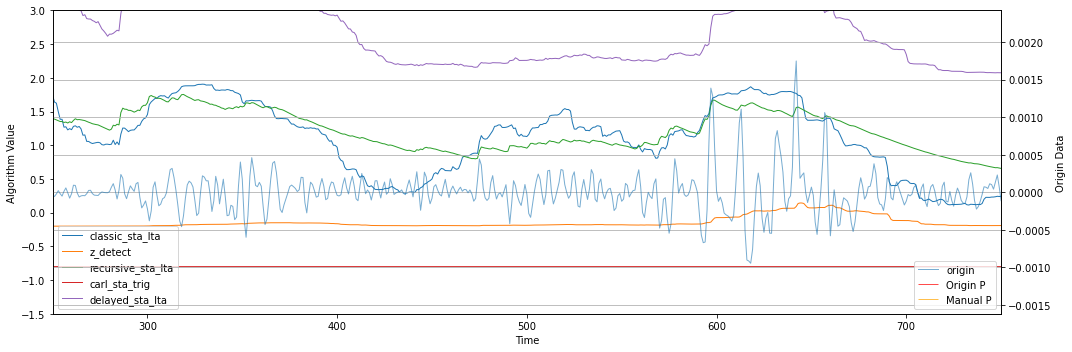

In [40]:
debugAlgFig(alg_lim=[-1.5,3])

In [41]:
# calculateWidgetData(data=SesiData["y"], sampling_rate=SesiData["sampling_rate"])

- 查看更新